In [2]:
import numpy as np
import pandas as pd
from pyod.models import iforest, ocsvm, cblof
from matplotlib import pyplot as plt
from matplotlib.backends import backend_pdf
from pyod import models
from sklearn import preprocessing, decomposition, metrics, ensemble, svm, cluster, linear_model
from itertools import count
import collections
import glob
import rpy2.robjects as robjects
from collections import OrderedDict
import datetime as dt
import time
import tweepy
import csv
import collections
import random
from collections import Counter
import string
import re
from wordcloud import WordCloud, STOPWORDS 

## Feature Engineering

In [2]:
def feature_engineering(filename):
    '''
    This function takes in the filename and splits the time component into hours, day of the week, and is it a weekday or not. 
    
    Args:
    -----
    filename : String
    
    Returns:
    --------
    df : pandas.DataFrame
    '''
    df = pd.read_csv(filename)
    df['datetime'] = pd.to_datetime(df['timestamps'] * (10**9))
    df = df[['value', 'anomaly', 'datetime', 'timestamps']]

    df['datetime'] = pd.to_datetime(df['datetime'])
    df['hours'] = df['datetime'].dt.hour
    df['day'] = df['datetime'].dt.dayofweek
    df['isweekday'] = (df['day'] < 5).astype(int)
    return df



## Helper function

In [3]:
random.seed(100)
outliers_fraction = 0.01

def plot_data(dataframe, anomaly, title):
    '''
    This function takes in the two dataframe and creates a plot for timeseries with anomaly. 
    
    Args:
    -----
    dataframe : pandas.DataFrame
    anomaly : pandas.DataFrame
    title : String
    
    '''
        

    dataframe = dataframe.sort_values(by = 'timestamps')
    plt.plot(dataframe['timestamps'], dataframe['value'], color='blue')
    plt.scatter(anomaly['timestamps'],anomaly['value'], color='red')
    plt.title(title)



def standardize(dataframe):
    
    '''
    This function takes in a dataframe and performs preprocessing using scaling. 
    
    Args:
    -----
    dataframe : pandas.DataFrame
    
    Returns:
    --------
    df : pandas.DataFrame
    '''
    
    dataframe = dataframe[['value', 'hours', 'day', 'isweekday']]
    trans_scalar = preprocessing.StandardScaler()
    data_scaled = trans_scalar.fit_transform(dataframe)
    data = pd.DataFrame(data_scaled)

    return data

def detrend(dataframe):
    
    '''
    This function takes in dataframe and removes the trend in value column. 
    
    Args:
    -----
    dataframe : pandas.DataFrame
    
    Returns:
    --------
    dataframe : pandas.DataFrame
    '''
    
    dataframe.index.name = 'Label'
    dataframe.reset_index(inplace = True)
    lm = linear_model.LinearRegression()
    X = dataframe['Label']
    y = dataframe['value']
    X = X.values
    X = X.reshape(-1,1)
    model = lm.fit(X,y)
    trend_val = float(lm.coef_)
    dataframe['value'] = dataframe['value'] - round(trend_val, 0) * dataframe['Label']
    dataframe.drop(['Label'], axis = 1)
    return(dataframe)



## Models

### Mean Plus Standard Deviation - Baseline

In [4]:
def mean_plus_standev(dataframe):
    
    '''
    This function takes in dataframe and identifies anomaly using mean + standard deviaton method. It adds a new column 
    called "mean_plus_standev" to our input dataframe that flags anomaly as 1. Also returns an anomaly dataframe, which is
    a subset of input dataframe when "mean_plus_standev" is 1.
    
    Args:
    -----
    dataframe : pandas.DataFrame
    
    Returns:
    --------
    dataframe : pandas.DataFrame
    anomaly : pandas.DataFrame
    '''
     
    sigma = 3
    anomalies = []
    y = dataframe["value"]
    upper_bound = y.mean() + sigma*y.std()
    lower_bound = y.mean() - sigma*y.std()

    anomalies = []
    for i in y.values:
        if i > upper_bound or i < lower_bound:
            anomalies.append(i)
            
    dataframe["mean_plus_standev"] = 0
    for i in range(len(data["value"])):
        
        if dataframe.value[i] in anomalies:
            dataframe.loc[i,"mean_plus_standev"] = 1
            
    
    anomaly = dataframe.loc[dataframe['mean_plus_standev'] == 1, ['timestamps', 'value']]
    
    return dataframe, anomaly

### Moving Average 

In [5]:
def moving_average(data, window_size):
    
    '''
    This function takes in dataframe and a window size and returns a list.
    
    Args:
    -----
    data : pandas.DataFrame
    window_size : Integer
    
    Returns:
    --------
    convolution : List
    '''

    data = data
    window = window_size
    output = []
    for i in range(window):
        output.append(data[:i+1])

    for i in range(1,len(data)):
   
        output.append(data[i:i+window])
    

    convolution = [sum(i)/window for i in output]
    extra = window-1

    if (extra)%2 == 0:
        half = int(extra/2)
        return(convolution[half:len(output)-half])
    
    else:
        first_half = int(extra//2)
        second_half = extra-first_half
        return(convolution[first_half:len(output)-second_half])

In [6]:
def moving_avg(dataframe):
    '''
    This function takes in dataframe and identifies anomaly using moving average method. It adds a new column 
    called "moving_avg" to our input dataframe that flags anomaly as 1. Also returns an anomaly dataframe, which is
    a subset of input dataframe when "moving_avg" is 1.
    
    Args:
    -----
    dataframe : pandas.DataFrame
    
    Returns:
    --------
    dataframe : pandas.DataFrame
    anomaly : pandas.DataFrame
    '''
    window_size = 10
    sigma = 3
    y = dataframe["value"]

    avg = moving_average(y, window_size)

    std = np.std(y)    
    anomalies = []
    
    for y_i,mean_i in zip(y,avg):       
        
        upper_bound = mean_i + (sigma*std)
        lower_bound = mean_i - (sigma*std)
        
        if (y_i > upper_bound) or (y_i < lower_bound): 

            anomalies.append(y_i)
            
    dataframe["moving_avg"] = 0
    
    for i in range(len(dataframe["value"])):
        if dataframe.value[i] in anomalies:
            dataframe.loc[i,"moving_avg"] = 1
    
    anomaly = dataframe.loc[dataframe['moving_avg'] == 1, ['timestamps', 'value']]
    return dataframe, anomaly

### Moving Average and Rolling Standard Deviation 

In [7]:
def moving_avg_rolling_std(dataframe):
    
    '''
    This function takes in dataframe and identifies anomaly using moving average rolling standard deviation method. It adds a new column 
    called "moving_avg_rolling_std" to our input dataframe that flags anomaly as 1. Also returns an anomaly dataframe, which is
    a subset of input dataframe when "moving_avg_rolling_std" is 1.
    
    Args:
    -----
    dataframe : pandas.DataFrame
    
    Returns:
    --------
    dataframe : pandas.DataFrame
    anomaly : pandas.DataFrame
    '''
    
    window_size = 10
    sigma = 2
    y = dataframe["value"]
    avg = moving_average(y, window_size)
    s = pd.DataFrame(y)
    
    rolling_stdev = s.rolling(window_size).std()    
    rolling_stdev_as_df = pd.DataFrame(rolling_stdev)

    temp = rolling_stdev_as_df.replace(np.nan,rolling_stdev_as_df.iloc[window_size - 1])
    #print(temp)
    rolling_stdev = list(temp.iloc[:,0])   
    anomalies = []
    
    for data_i, rolling_mean_i, rolling_std_i in zip(y, avg, rolling_stdev):
        
        upper_bound = rolling_mean_i + (sigma * rolling_std_i)
        lower_bound = rolling_mean_i - (sigma * rolling_std_i)
        
        if (data_i > upper_bound) | (data_i < lower_bound):
            
            anomalies.append(data_i)

    dataframe["moving_avg_rolling_std"] = 0
    for i in range(len(dataframe["value"])):
        if dataframe.value[i] in anomalies:
            dataframe.loc[i,"moving_avg_rolling_std"] = 1
    
    
    anomaly = dataframe.loc[dataframe['moving_avg_rolling_std'] == 1, ['timestamps', 'value']]
    return dataframe, anomaly

### K Means 

In [8]:
def get_distance(data, model):
    
    '''
    An helper function to calculate distance to the cluster center for K Means.
    
    Args:
    -----
    data : pandas.DataFrame
    
    Returns:
    --------
    distance : pd.Series()
    '''
    
    distance = pd.Series()
    
    for i in range(0,len(data)):

        distance.at[i] = np.linalg.norm(np.array(data.loc[i]) - model.cluster_centers_[model.labels_[i]-1])
    
    return distance

def kmeans(dataframe):
    
    '''
    This function takes in dataframe and identifies anomaly using K means clustering method. It adds a new column 
    called "kmeans" to our input dataframe that flags anomaly as 1. Also returns an anomaly dataframe, which is
    a subset of input dataframe when "kmeans" is 1.
    
    Args:
    -----
    dataframe : pandas.DataFrame
    
    Returns:
    --------
    dataframe : pandas.DataFrame
    anomaly : pandas.DataFrame
    '''
      
    data = standardize(dataframe)
    
    data = pd.DataFrame(data)

    
    distance = get_distance(data, cluster.KMeans(n_clusters = 4, random_state = 20).fit(data))
    number_of_outliers = int(outliers_fraction * len(distance))
    threshold = distance.nlargest(number_of_outliers).min()
    
    dataframe['kmeans'] = (distance >= threshold).astype(int)
    
    anomaly = dataframe.loc[dataframe['kmeans'] == 1, ['timestamps', 'value']] 
    
    return dataframe, anomaly




### Isolation Forest 

In [9]:
def isolation_forest(dataframe):
    
    '''
    This function takes in dataframe and identifies anomaly using Isolation Forest method. It adds a new column 
    called "isolation_forest" to our input dataframe that flags anomaly as 1. Also returns an anomaly dataframe, which is
    a subset of input dataframe when "isolation_forest" is 1.
    
    Args:
    -----
    dataframe : pandas.DataFrame
    
    Returns:
    --------
    dataframe : pandas.DataFrame
    anomaly : pandas.DataFrame
    '''
   
    data = standardize(dataframe)
    
    model =  ensemble.IsolationForest(contamination = outliers_fraction)
    model.fit(data)
 
    dataframe['isolation_forest'] = pd.Series(model.predict(data))
    dataframe['isolation_forest'] = dataframe['isolation_forest'].map( {1: 0, -1: 1} )
    
    anomaly = dataframe.loc[dataframe['isolation_forest'] == 1, ['timestamps', 'value']]
    return dataframe, anomaly


### One Class SVM 

In [10]:
def one_class_svm(dataframe):
    
    '''
    This function takes in dataframe and identifies anomaly using One Class SVM method. It adds a new column 
    called "isolation_forest_pyod" to our input dataframe that flags anomaly as 1. Also returns an anomaly dataframe, which is
    a subset of input dataframe when "isolation_forest_pyod" is 1.
    
    Args:
    -----
    dataframe : pandas.DataFrame
    
    Returns:
    --------
    dataframe : pandas.DataFrame
    anomaly : pandas.DataFrame
    '''
   
    data = standardize(dataframe)
    
    model =  svm.OneClassSVM() 
    model.fit(data)

    prob = model.decision_function(data)
    dataframe['dist'] = prob.reshape(prob.shape[0],)
    
    dataframe['one_class_svm'] = 0
    
    threshold = np.percentile(dataframe['dist'], outliers_fraction * 100)

    dataframe.loc[dataframe['dist'] < threshold, 'one_class_svm'] = 1 


    dataframe.drop(['dist'], axis = 1)
    

    
    anomaly = dataframe.loc[dataframe['one_class_svm'] == 1, ['timestamps', 'value']]
    return dataframe, anomaly



### Max Voting

In [12]:
def max_voting(dataframe):
    '''
    This function takes in dataframe and identifies anomaly using max voting method on the output of K Means, Isolation Forest,
    and One Class SVM. It adds a new column called "max_voting" to our input dataframe that flags anomaly as 1. 
    Also returns an anomaly dataframe, which is a subset of input dataframe when "max_voting" is 1.
    
    Args:
    -----
    dataframe : pandas.DataFrame
    
    Returns:
    --------
    dataframe : pandas.DataFrame
    anomaly : pandas.DataFrame
    '''
    
    treshold = 2
    dataframe['max_voting'] = dataframe['kmeans'] + dataframe['isolation_forest'] + dataframe['one_class_svm'] +dataframe['moving_avg_rolling_std']
    dataframe['max_voting'] = np.where(dataframe['max_voting'] >= treshold, 1, 0)

    anomaly = dataframe.loc[dataframe['max_voting'] == 1, ['timestamps', 'value']]
    return dataframe, anomaly


### Implementation in Yahoo Dataset 

In [13]:
file_array = [f for f in glob.glob("A1Benchmark/*.csv")]

columns = ["File", "Method", "TN", "FP", "FN", "TP", "Precision", "Recall", "F1"]

accuracy_df = pd.DataFrame(columns = columns) 

file_counter = 1

for f in file_array:
    print(f)
    data = feature_engineering(f)
    data = detrend(data)

    functions = ['mean_plus_standev', 'kmeans', 'moving_avg', 'moving_avg_rolling_std', 'isolation_forest', 'one_class_svm', 'max_voting']
    
    pdf = backend_pdf.PdfPages("Output/" + f.split("\\")[1] + ".pdf")
    fig = plot_data(data, data.loc[data["anomaly"] == 1], "Original Anomalies")
    pdf.savefig(fig)
    plt.close()
    
    for fun in functions:
        func = globals()[fun]
        data, anomaly = func(data)

        fig = plot_data(data, anomaly, fun)
        pdf.savefig(fig)
        plt.close()
        
        row = [f.split("\\")[1], fun] + list(np.array(metrics.confusion_matrix(data['anomaly'], data[fun])).flatten())
        
        precision =  round(metrics.precision_score(data['anomaly'], data[fun]), 3)
        row.append(precision)
        
        recall =  round(metrics.recall_score(data['anomaly'], data[fun]), 3)
        row.append(recall)

        f1_score =  round(metrics.f1_score(data['anomaly'], data[fun]), 3)
        row.append(f1_score)
        
        row_dict = {accuracy_df.columns[i] : row[i] for i in range(len(row))}
        print(row_dict)
        accuracy_df = accuracy_df.append(row_dict, ignore_index = True)
    
    pdf.close()
    plt.close('all')
    file_counter += 1    
   

A1Benchmark\TS1.csv
{'File': 'TS1.csv', 'Method': 'mean_plus_standev', 'TN': 1669, 'FP': 0, 'FN': 6, 'TP': 5, 'Precision': 1.0, 'Recall': 0.455, 'F1': 0.625}
{'File': 'TS1.csv', 'Method': 'kmeans', 'TN': 1661, 'FP': 8, 'FN': 3, 'TP': 8, 'Precision': 0.5, 'Recall': 0.727, 'F1': 0.593}
{'File': 'TS1.csv', 'Method': 'moving_avg', 'TN': 1669, 'FP': 0, 'FN': 7, 'TP': 4, 'Precision': 1.0, 'Recall': 0.364, 'F1': 0.533}
{'File': 'TS1.csv', 'Method': 'moving_avg_rolling_std', 'TN': 1667, 'FP': 2, 'FN': 3, 'TP': 8, 'Precision': 0.8, 'Recall': 0.727, 'F1': 0.762}
{'File': 'TS1.csv', 'Method': 'isolation_forest', 'TN': 1659, 'FP': 10, 'FN': 4, 'TP': 7, 'Precision': 0.412, 'Recall': 0.636, 'F1': 0.5}
{'File': 'TS1.csv', 'Method': 'one_class_svm', 'TN': 1662, 'FP': 7, 'FN': 1, 'TP': 10, 'Precision': 0.588, 'Recall': 0.909, 'F1': 0.714}
{'File': 'TS1.csv', 'Method': 'max_voting', 'TN': 1661, 'FP': 8, 'FN': 2, 'TP': 9, 'Precision': 0.529, 'Recall': 0.818, 'F1': 0.643}
A1Benchmark\TS10.csv
{'File': 'TS

D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'File': 'TS14.csv', 'Method': 'moving_avg', 'TN': 1669, 'FP': 0, 'FN': 11, 'TP': 0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
{'File': 'TS14.csv', 'Method': 'moving_avg_rolling_std', 'TN': 1669, 'FP': 0, 'FN': 5, 'TP': 6, 'Precision': 1.0, 'Recall': 0.545, 'F1': 0.706}
{'File': 'TS14.csv', 'Method': 'isolation_forest', 'TN': 1656, 'FP': 13, 'FN': 7, 'TP': 4, 'Precision': 0.235, 'Recall': 0.364, 'F1': 0.286}
{'File': 'TS14.csv', 'Method': 'one_class_svm', 'TN': 1659, 'FP': 10, 'FN': 4, 'TP': 7, 'Precision': 0.412, 'Recall': 0.636, 'F1': 0.5}
{'File': 'TS14.csv', 'Method': 'max_voting', 'TN': 1669, 'FP': 0, 'FN': 4, 'TP': 7, 'Precision': 1.0, 'Recall': 0.636, 'F1': 0.778}
A1Benchmark\TS15.csv
{'File': 'TS15.csv', 'Method': 'mean_plus_standev', 'TN': 1676, 'FP': 0, 'FN': 3, 'TP': 1, 'Precision': 1.0, 'Recall': 0.25, 'F1': 0.4}
{'File': 'TS15.csv', 'Method': 'kmeans', 'TN': 1661, 'FP': 15, 'FN': 3, 'TP': 1, 'Precision': 0.062, 'Recall': 0.25, 'F1': 0.1}
{'File': 'TS15.csv', 'Method': 'm

D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'File': 'TS21.csv', 'Method': 'mean_plus_standev', 'TN': 1676, 'FP': 0, 'FN': 4, 'TP': 0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
{'File': 'TS21.csv', 'Method': 'kmeans', 'TN': 1661, 'FP': 15, 'FN': 3, 'TP': 1, 'Precision': 0.062, 'Recall': 0.25, 'F1': 0.1}
{'File': 'TS21.csv', 'Method': 'moving_avg', 'TN': 1676, 'FP': 0, 'FN': 4, 'TP': 0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
{'File': 'TS21.csv', 'Method': 'moving_avg_rolling_std', 'TN': 1676, 'FP': 0, 'FN': 2, 'TP': 2, 'Precision': 1.0, 'Recall': 0.5, 'F1': 0.667}
{'File': 'TS21.csv', 'Method': 'isolation_forest', 'TN': 1661, 'FP': 15, 'FN': 2, 'TP': 2, 'Precision': 0.118, 'Recall': 0.5, 'F1': 0.19}
{'File': 'TS21.csv', 'Method': 'one_class_svm', 'TN': 1663, 'FP': 13, 'FN': 0, 'TP': 4, 'Precision': 0.235, 'Recall': 1.0, 'F1': 0.381}
{'File': 'TS21.csv', 'Method': 'max_voting', 'TN': 1669, 'FP': 7, 'FN': 1, 'TP': 3, 'Precision': 0.3, 'Recall': 0.75, 'F1': 0.429}
A1Benchmark\TS22.csv
{'File': 'TS22.csv', 'Method': 'mean_plus

D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'File': 'TS23.csv', 'Method': 'moving_avg', 'TN': 1668, 'FP': 0, 'FN': 12, 'TP': 0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
{'File': 'TS23.csv', 'Method': 'moving_avg_rolling_std', 'TN': 1657, 'FP': 11, 'FN': 5, 'TP': 7, 'Precision': 0.389, 'Recall': 0.583, 'F1': 0.467}
{'File': 'TS23.csv', 'Method': 'isolation_forest', 'TN': 1660, 'FP': 8, 'FN': 3, 'TP': 9, 'Precision': 0.529, 'Recall': 0.75, 'F1': 0.621}
{'File': 'TS23.csv', 'Method': 'one_class_svm', 'TN': 1659, 'FP': 9, 'FN': 4, 'TP': 8, 'Precision': 0.471, 'Recall': 0.667, 'F1': 0.552}
{'File': 'TS23.csv', 'Method': 'max_voting', 'TN': 1662, 'FP': 6, 'FN': 4, 'TP': 8, 'Precision': 0.571, 'Recall': 0.667, 'F1': 0.615}
A1Benchmark\TS24.csv
{'File': 'TS24.csv', 'Method': 'mean_plus_standev', 'TN': 1670, 'FP': 0, 'FN': 3, 'TP': 7, 'Precision': 1.0, 'Recall': 0.7, 'F1': 0.824}
{'File': 'TS24.csv', 'Method': 'kmeans', 'TN': 1661, 'FP': 9, 'FN': 3, 'TP': 7, 'Precision': 0.438, 'Recall': 0.7, 'F1': 0.538}
{'File': 'TS24.csv', 'Method

D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'File': 'TS25.csv', 'Method': 'moving_avg', 'TN': 1664, 'FP': 0, 'FN': 16, 'TP': 0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
{'File': 'TS25.csv', 'Method': 'moving_avg_rolling_std', 'TN': 1664, 'FP': 0, 'FN': 13, 'TP': 3, 'Precision': 1.0, 'Recall': 0.188, 'F1': 0.316}
{'File': 'TS25.csv', 'Method': 'isolation_forest', 'TN': 1652, 'FP': 12, 'FN': 11, 'TP': 5, 'Precision': 0.294, 'Recall': 0.312, 'F1': 0.303}
{'File': 'TS25.csv', 'Method': 'one_class_svm', 'TN': 1660, 'FP': 4, 'FN': 3, 'TP': 13, 'Precision': 0.765, 'Recall': 0.812, 'F1': 0.788}
{'File': 'TS25.csv', 'Method': 'max_voting', 'TN': 1657, 'FP': 7, 'FN': 10, 'TP': 6, 'Precision': 0.462, 'Recall': 0.375, 'F1': 0.414}
A1Benchmark\TS26.csv
{'File': 'TS26.csv', 'Method': 'mean_plus_standev', 'TN': 1664, 'FP': 0, 'FN': 11, 'TP': 5, 'Precision': 1.0, 'Recall': 0.312, 'F1': 0.476}
{'File': 'TS26.csv', 'Method': 'kmeans', 'TN': 1654, 'FP': 10, 'FN': 10, 'TP': 6, 'Precision': 0.375, 'Recall': 0.375, 'F1': 0.375}
{'File': 'TS26.csv

D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'File': 'TS27.csv', 'Method': 'moving_avg', 'TN': 1675, 'FP': 0, 'FN': 5, 'TP': 0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
{'File': 'TS27.csv', 'Method': 'moving_avg_rolling_std', 'TN': 1664, 'FP': 11, 'FN': 1, 'TP': 4, 'Precision': 0.267, 'Recall': 0.8, 'F1': 0.4}
{'File': 'TS27.csv', 'Method': 'isolation_forest', 'TN': 1660, 'FP': 15, 'FN': 3, 'TP': 2, 'Precision': 0.118, 'Recall': 0.4, 'F1': 0.182}
{'File': 'TS27.csv', 'Method': 'one_class_svm', 'TN': 1662, 'FP': 13, 'FN': 1, 'TP': 4, 'Precision': 0.235, 'Recall': 0.8, 'F1': 0.364}
{'File': 'TS27.csv', 'Method': 'max_voting', 'TN': 1666, 'FP': 9, 'FN': 1, 'TP': 4, 'Precision': 0.308, 'Recall': 0.8, 'F1': 0.444}
A1Benchmark\TS28.csv
{'File': 'TS28.csv', 'Method': 'mean_plus_standev', 'TN': 1677, 'FP': 0, 'FN': 2, 'TP': 1, 'Precision': 1.0, 'Recall': 0.333, 'F1': 0.5}
{'File': 'TS28.csv', 'Method': 'kmeans', 'TN': 1664, 'FP': 13, 'FN': 0, 'TP': 3, 'Precision': 0.188, 'Recall': 1.0, 'F1': 0.316}


D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'File': 'TS28.csv', 'Method': 'moving_avg', 'TN': 1677, 'FP': 0, 'FN': 3, 'TP': 0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
{'File': 'TS28.csv', 'Method': 'moving_avg_rolling_std', 'TN': 1676, 'FP': 1, 'FN': 2, 'TP': 1, 'Precision': 0.5, 'Recall': 0.333, 'F1': 0.4}
{'File': 'TS28.csv', 'Method': 'isolation_forest', 'TN': 1663, 'FP': 14, 'FN': 0, 'TP': 3, 'Precision': 0.176, 'Recall': 1.0, 'F1': 0.3}
{'File': 'TS28.csv', 'Method': 'one_class_svm', 'TN': 1663, 'FP': 14, 'FN': 0, 'TP': 3, 'Precision': 0.176, 'Recall': 1.0, 'F1': 0.3}
{'File': 'TS28.csv', 'Method': 'max_voting', 'TN': 1671, 'FP': 6, 'FN': 0, 'TP': 3, 'Precision': 0.333, 'Recall': 1.0, 'F1': 0.5}
A1Benchmark\TS29.csv
{'File': 'TS29.csv', 'Method': 'mean_plus_standev', 'TN': 1665, 'FP': 0, 'FN': 8, 'TP': 7, 'Precision': 1.0, 'Recall': 0.467, 'F1': 0.636}
{'File': 'TS29.csv', 'Method': 'kmeans', 'TN': 1655, 'FP': 10, 'FN': 9, 'TP': 6, 'Precision': 0.375, 'Recall': 0.4, 'F1': 0.387}
{'File': 'TS29.csv', 'Method': 'moving_a

D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'File': 'TS3.csv', 'Method': 'moving_avg', 'TN': 1670, 'FP': 0, 'FN': 10, 'TP': 0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
{'File': 'TS3.csv', 'Method': 'moving_avg_rolling_std', 'TN': 1670, 'FP': 0, 'FN': 6, 'TP': 4, 'Precision': 1.0, 'Recall': 0.4, 'F1': 0.571}
{'File': 'TS3.csv', 'Method': 'isolation_forest', 'TN': 1659, 'FP': 11, 'FN': 4, 'TP': 6, 'Precision': 0.353, 'Recall': 0.6, 'F1': 0.444}
{'File': 'TS3.csv', 'Method': 'one_class_svm', 'TN': 1660, 'FP': 10, 'FN': 3, 'TP': 7, 'Precision': 0.412, 'Recall': 0.7, 'F1': 0.519}
{'File': 'TS3.csv', 'Method': 'max_voting', 'TN': 1670, 'FP': 0, 'FN': 3, 'TP': 7, 'Precision': 1.0, 'Recall': 0.7, 'F1': 0.824}
A1Benchmark\TS30.csv


D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'File': 'TS30.csv', 'Method': 'mean_plus_standev', 'TN': 1667, 'FP': 0, 'FN': 13, 'TP': 0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
{'File': 'TS30.csv', 'Method': 'kmeans', 'TN': 1652, 'FP': 15, 'FN': 12, 'TP': 1, 'Precision': 0.062, 'Recall': 0.077, 'F1': 0.069}
{'File': 'TS30.csv', 'Method': 'moving_avg', 'TN': 1667, 'FP': 0, 'FN': 13, 'TP': 0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
{'File': 'TS30.csv', 'Method': 'moving_avg_rolling_std', 'TN': 1662, 'FP': 5, 'FN': 7, 'TP': 6, 'Precision': 0.545, 'Recall': 0.462, 'F1': 0.5}
{'File': 'TS30.csv', 'Method': 'isolation_forest', 'TN': 1659, 'FP': 8, 'FN': 4, 'TP': 9, 'Precision': 0.529, 'Recall': 0.692, 'F1': 0.6}
{'File': 'TS30.csv', 'Method': 'one_class_svm', 'TN': 1659, 'FP': 8, 'FN': 4, 'TP': 9, 'Precision': 0.529, 'Recall': 0.692, 'F1': 0.6}
{'File': 'TS30.csv', 'Method': 'max_voting', 'TN': 1662, 'FP': 5, 'FN': 4, 'TP': 9, 'Precision': 0.643, 'Recall': 0.692, 'F1': 0.667}
A1Benchmark\TS31.csv
{'File': 'TS31.csv', 'Method': 

D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'File': 'TS32.csv', 'Method': 'moving_avg', 'TN': 1673, 'FP': 0, 'FN': 7, 'TP': 0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
{'File': 'TS32.csv', 'Method': 'moving_avg_rolling_std', 'TN': 1671, 'FP': 2, 'FN': 5, 'TP': 2, 'Precision': 0.5, 'Recall': 0.286, 'F1': 0.364}
{'File': 'TS32.csv', 'Method': 'isolation_forest', 'TN': 1660, 'FP': 13, 'FN': 3, 'TP': 4, 'Precision': 0.235, 'Recall': 0.571, 'F1': 0.333}
{'File': 'TS32.csv', 'Method': 'one_class_svm', 'TN': 1661, 'FP': 12, 'FN': 2, 'TP': 5, 'Precision': 0.294, 'Recall': 0.714, 'F1': 0.417}
{'File': 'TS32.csv', 'Method': 'max_voting', 'TN': 1663, 'FP': 10, 'FN': 3, 'TP': 4, 'Precision': 0.286, 'Recall': 0.571, 'F1': 0.381}
A1Benchmark\TS33.csv
{'File': 'TS33.csv', 'Method': 'mean_plus_standev', 'TN': 1667, 'FP': 0, 'FN': 10, 'TP': 3, 'Precision': 1.0, 'Recall': 0.231, 'F1': 0.375}
{'File': 'TS33.csv', 'Method': 'kmeans', 'TN': 1653, 'FP': 14, 'FN': 11, 'TP': 2, 'Precision': 0.125, 'Recall': 0.154, 'F1': 0.138}
{'File': 'TS33.csv', 

D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'File': 'TS38.csv', 'Method': 'moving_avg', 'TN': 1669, 'FP': 0, 'FN': 11, 'TP': 0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
{'File': 'TS38.csv', 'Method': 'moving_avg_rolling_std', 'TN': 1659, 'FP': 10, 'FN': 3, 'TP': 8, 'Precision': 0.444, 'Recall': 0.727, 'F1': 0.552}
{'File': 'TS38.csv', 'Method': 'isolation_forest', 'TN': 1660, 'FP': 9, 'FN': 3, 'TP': 8, 'Precision': 0.471, 'Recall': 0.727, 'F1': 0.571}
{'File': 'TS38.csv', 'Method': 'one_class_svm', 'TN': 1662, 'FP': 7, 'FN': 1, 'TP': 10, 'Precision': 0.588, 'Recall': 0.909, 'F1': 0.714}
{'File': 'TS38.csv', 'Method': 'max_voting', 'TN': 1663, 'FP': 6, 'FN': 2, 'TP': 9, 'Precision': 0.6, 'Recall': 0.818, 'F1': 0.692}
A1Benchmark\TS39.csv
{'File': 'TS39.csv', 'Method': 'mean_plus_standev', 'TN': 1674, 'FP': 0, 'FN': 4, 'TP': 2, 'Precision': 1.0, 'Recall': 0.333, 'F1': 0.5}
{'File': 'TS39.csv', 'Method': 'kmeans', 'TN': 1661, 'FP': 13, 'FN': 3, 'TP': 3, 'Precision': 0.188, 'Recall': 0.5, 'F1': 0.273}
{'File': 'TS39.csv', 'Metho

D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'File': 'TS44.csv', 'Method': 'mean_plus_standev', 'TN': 1679, 'FP': 0, 'FN': 1, 'TP': 0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
{'File': 'TS44.csv', 'Method': 'kmeans', 'TN': 1663, 'FP': 16, 'FN': 1, 'TP': 0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
{'File': 'TS44.csv', 'Method': 'moving_avg', 'TN': 1679, 'FP': 0, 'FN': 1, 'TP': 0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
{'File': 'TS44.csv', 'Method': 'moving_avg_rolling_std', 'TN': 1679, 'FP': 0, 'FN': 0, 'TP': 1, 'Precision': 1.0, 'Recall': 1.0, 'F1': 1.0}
{'File': 'TS44.csv', 'Method': 'isolation_forest', 'TN': 1663, 'FP': 16, 'FN': 0, 'TP': 1, 'Precision': 0.059, 'Recall': 1.0, 'F1': 0.111}
{'File': 'TS44.csv', 'Method': 'one_class_svm', 'TN': 1663, 'FP': 16, 'FN': 0, 'TP': 1, 'Precision': 0.059, 'Recall': 1.0, 'F1': 0.111}
{'File': 'TS44.csv', 'Method': 'max_voting', 'TN': 1679, 'FP': 0, 'FN': 0, 'TP': 1, 'Precision': 1.0, 'Recall': 1.0, 'F1': 1.0}
A1Benchmark\TS45.csv
{'File': 'TS45.csv', 'Method': 'mean_plus_stande

D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'File': 'TS48.csv', 'Method': 'moving_avg', 'TN': 1675, 'FP': 0, 'FN': 5, 'TP': 0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
{'File': 'TS48.csv', 'Method': 'moving_avg_rolling_std', 'TN': 1674, 'FP': 1, 'FN': 4, 'TP': 1, 'Precision': 0.5, 'Recall': 0.2, 'F1': 0.286}
{'File': 'TS48.csv', 'Method': 'isolation_forest', 'TN': 1661, 'FP': 14, 'FN': 2, 'TP': 3, 'Precision': 0.176, 'Recall': 0.6, 'F1': 0.273}
{'File': 'TS48.csv', 'Method': 'one_class_svm', 'TN': 1663, 'FP': 12, 'FN': 0, 'TP': 5, 'Precision': 0.294, 'Recall': 1.0, 'F1': 0.455}
{'File': 'TS48.csv', 'Method': 'max_voting', 'TN': 1671, 'FP': 4, 'FN': 2, 'TP': 3, 'Precision': 0.429, 'Recall': 0.6, 'F1': 0.5}
A1Benchmark\TS49.csv
{'File': 'TS49.csv', 'Method': 'mean_plus_standev', 'TN': 1671, 'FP': 0, 'FN': 4, 'TP': 5, 'Precision': 1.0, 'Recall': 0.556, 'F1': 0.714}
{'File': 'TS49.csv', 'Method': 'kmeans', 'TN': 1657, 'FP': 14, 'FN': 7, 'TP': 2, 'Precision': 0.125, 'Recall': 0.222, 'F1': 0.16}
{'File': 'TS49.csv', 'Method': 'mov

D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'File': 'TS5.csv', 'Method': 'mean_plus_standev', 'TN': 1671, 'FP': 0, 'FN': 9, 'TP': 0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
{'File': 'TS5.csv', 'Method': 'kmeans', 'TN': 1656, 'FP': 15, 'FN': 8, 'TP': 1, 'Precision': 0.062, 'Recall': 0.111, 'F1': 0.08}
{'File': 'TS5.csv', 'Method': 'moving_avg', 'TN': 1671, 'FP': 0, 'FN': 9, 'TP': 0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
{'File': 'TS5.csv', 'Method': 'moving_avg_rolling_std', 'TN': 1671, 'FP': 0, 'FN': 3, 'TP': 6, 'Precision': 1.0, 'Recall': 0.667, 'F1': 0.8}
{'File': 'TS5.csv', 'Method': 'isolation_forest', 'TN': 1660, 'FP': 11, 'FN': 3, 'TP': 6, 'Precision': 0.353, 'Recall': 0.667, 'F1': 0.462}
{'File': 'TS5.csv', 'Method': 'one_class_svm', 'TN': 1662, 'FP': 9, 'FN': 1, 'TP': 8, 'Precision': 0.471, 'Recall': 0.889, 'F1': 0.615}
{'File': 'TS5.csv', 'Method': 'max_voting', 'TN': 1670, 'FP': 1, 'FN': 1, 'TP': 8, 'Precision': 0.889, 'Recall': 0.889, 'F1': 0.889}
A1Benchmark\TS50.csv
{'File': 'TS50.csv', 'Method': 'mean_pl

D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'File': 'TS50.csv', 'Method': 'moving_avg', 'TN': 1665, 'FP': 0, 'FN': 15, 'TP': 0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
{'File': 'TS50.csv', 'Method': 'moving_avg_rolling_std', 'TN': 1650, 'FP': 15, 'FN': 7, 'TP': 8, 'Precision': 0.348, 'Recall': 0.533, 'F1': 0.421}
{'File': 'TS50.csv', 'Method': 'isolation_forest', 'TN': 1656, 'FP': 9, 'FN': 7, 'TP': 8, 'Precision': 0.471, 'Recall': 0.533, 'F1': 0.5}
{'File': 'TS50.csv', 'Method': 'one_class_svm', 'TN': 1657, 'FP': 8, 'FN': 6, 'TP': 9, 'Precision': 0.529, 'Recall': 0.6, 'F1': 0.562}
{'File': 'TS50.csv', 'Method': 'max_voting', 'TN': 1659, 'FP': 6, 'FN': 7, 'TP': 8, 'Precision': 0.571, 'Recall': 0.533, 'F1': 0.552}
A1Benchmark\TS51.csv
{'File': 'TS51.csv', 'Method': 'mean_plus_standev', 'TN': 1674, 'FP': 0, 'FN': 4, 'TP': 2, 'Precision': 1.0, 'Recall': 0.333, 'F1': 0.5}
{'File': 'TS51.csv', 'Method': 'kmeans', 'TN': 1660, 'FP': 14, 'FN': 4, 'TP': 2, 'Precision': 0.125, 'Recall': 0.333, 'F1': 0.182}
{'File': 'TS51.csv', 'Method

D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'File': 'TS52.csv', 'Method': 'moving_avg', 'TN': 1666, 'FP': 0, 'FN': 14, 'TP': 0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
{'File': 'TS52.csv', 'Method': 'moving_avg_rolling_std', 'TN': 1659, 'FP': 7, 'FN': 6, 'TP': 8, 'Precision': 0.533, 'Recall': 0.571, 'F1': 0.552}
{'File': 'TS52.csv', 'Method': 'isolation_forest', 'TN': 1655, 'FP': 11, 'FN': 8, 'TP': 6, 'Precision': 0.353, 'Recall': 0.429, 'F1': 0.387}
{'File': 'TS52.csv', 'Method': 'one_class_svm', 'TN': 1661, 'FP': 5, 'FN': 2, 'TP': 12, 'Precision': 0.706, 'Recall': 0.857, 'F1': 0.774}
{'File': 'TS52.csv', 'Method': 'max_voting', 'TN': 1665, 'FP': 1, 'FN': 3, 'TP': 11, 'Precision': 0.917, 'Recall': 0.786, 'F1': 0.846}
A1Benchmark\TS53.csv
{'File': 'TS53.csv', 'Method': 'mean_plus_standev', 'TN': 1664, 'FP': 0, 'FN': 8, 'TP': 8, 'Precision': 1.0, 'Recall': 0.5, 'F1': 0.667}
{'File': 'TS53.csv', 'Method': 'kmeans', 'TN': 1654, 'FP': 10, 'FN': 10, 'TP': 6, 'Precision': 0.375, 'Recall': 0.375, 'F1': 0.375}
{'File': 'TS53.csv', 

D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'File': 'TS57.csv', 'Method': 'mean_plus_standev', 'TN': 1673, 'FP': 0, 'FN': 7, 'TP': 0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
{'File': 'TS57.csv', 'Method': 'kmeans', 'TN': 1659, 'FP': 14, 'FN': 5, 'TP': 2, 'Precision': 0.125, 'Recall': 0.286, 'F1': 0.174}
{'File': 'TS57.csv', 'Method': 'moving_avg', 'TN': 1673, 'FP': 0, 'FN': 7, 'TP': 0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
{'File': 'TS57.csv', 'Method': 'moving_avg_rolling_std', 'TN': 1657, 'FP': 16, 'FN': 4, 'TP': 3, 'Precision': 0.158, 'Recall': 0.429, 'F1': 0.231}
{'File': 'TS57.csv', 'Method': 'isolation_forest', 'TN': 1660, 'FP': 13, 'FN': 3, 'TP': 4, 'Precision': 0.235, 'Recall': 0.571, 'F1': 0.333}
{'File': 'TS57.csv', 'Method': 'one_class_svm', 'TN': 1660, 'FP': 13, 'FN': 3, 'TP': 4, 'Precision': 0.235, 'Recall': 0.571, 'F1': 0.333}
{'File': 'TS57.csv', 'Method': 'max_voting', 'TN': 1664, 'FP': 9, 'FN': 3, 'TP': 4, 'Precision': 0.308, 'Recall': 0.571, 'F1': 0.4}
A1Benchmark\TS58.csv
{'File': 'TS58.csv', 'Metho

D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'File': 'TS58.csv', 'Method': 'moving_avg', 'TN': 1668, 'FP': 0, 'FN': 12, 'TP': 0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
{'File': 'TS58.csv', 'Method': 'moving_avg_rolling_std', 'TN': 1663, 'FP': 5, 'FN': 7, 'TP': 5, 'Precision': 0.5, 'Recall': 0.417, 'F1': 0.455}
{'File': 'TS58.csv', 'Method': 'isolation_forest', 'TN': 1659, 'FP': 9, 'FN': 4, 'TP': 8, 'Precision': 0.471, 'Recall': 0.667, 'F1': 0.552}
{'File': 'TS58.csv', 'Method': 'one_class_svm', 'TN': 1662, 'FP': 6, 'FN': 1, 'TP': 11, 'Precision': 0.647, 'Recall': 0.917, 'F1': 0.759}
{'File': 'TS58.csv', 'Method': 'max_voting', 'TN': 1667, 'FP': 1, 'FN': 3, 'TP': 9, 'Precision': 0.9, 'Recall': 0.75, 'F1': 0.818}
A1Benchmark\TS59.csv
{'File': 'TS59.csv', 'Method': 'mean_plus_standev', 'TN': 1672, 'FP': 0, 'FN': 7, 'TP': 1, 'Precision': 1.0, 'Recall': 0.125, 'F1': 0.222}
{'File': 'TS59.csv', 'Method': 'kmeans', 'TN': 1657, 'FP': 15, 'FN': 7, 'TP': 1, 'Precision': 0.062, 'Recall': 0.125, 'F1': 0.083}


D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'File': 'TS59.csv', 'Method': 'moving_avg', 'TN': 1672, 'FP': 0, 'FN': 8, 'TP': 0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
{'File': 'TS59.csv', 'Method': 'moving_avg_rolling_std', 'TN': 1670, 'FP': 2, 'FN': 2, 'TP': 6, 'Precision': 0.75, 'Recall': 0.75, 'F1': 0.75}
{'File': 'TS59.csv', 'Method': 'isolation_forest', 'TN': 1660, 'FP': 12, 'FN': 2, 'TP': 6, 'Precision': 0.333, 'Recall': 0.75, 'F1': 0.462}
{'File': 'TS59.csv', 'Method': 'one_class_svm', 'TN': 1661, 'FP': 11, 'FN': 2, 'TP': 6, 'Precision': 0.353, 'Recall': 0.75, 'F1': 0.48}
{'File': 'TS59.csv', 'Method': 'max_voting', 'TN': 1669, 'FP': 3, 'FN': 2, 'TP': 6, 'Precision': 0.667, 'Recall': 0.75, 'F1': 0.706}
A1Benchmark\TS6.csv
{'File': 'TS6.csv', 'Method': 'mean_plus_standev', 'TN': 1665, 'FP': 0, 'FN': 10, 'TP': 5, 'Precision': 1.0, 'Recall': 0.333, 'F1': 0.5}
{'File': 'TS6.csv', 'Method': 'kmeans', 'TN': 1652, 'FP': 13, 'FN': 12, 'TP': 3, 'Precision': 0.188, 'Recall': 0.2, 'F1': 0.194}
{'File': 'TS6.csv', 'Method': 'mov

D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'File': 'TS61.csv', 'Method': 'moving_avg', 'TN': 1673, 'FP': 0, 'FN': 7, 'TP': 0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
{'File': 'TS61.csv', 'Method': 'moving_avg_rolling_std', 'TN': 1671, 'FP': 2, 'FN': 5, 'TP': 2, 'Precision': 0.5, 'Recall': 0.286, 'F1': 0.364}
{'File': 'TS61.csv', 'Method': 'isolation_forest', 'TN': 1658, 'FP': 15, 'FN': 5, 'TP': 2, 'Precision': 0.118, 'Recall': 0.286, 'F1': 0.167}
{'File': 'TS61.csv', 'Method': 'one_class_svm', 'TN': 1660, 'FP': 13, 'FN': 3, 'TP': 4, 'Precision': 0.235, 'Recall': 0.571, 'F1': 0.333}
{'File': 'TS61.csv', 'Method': 'max_voting', 'TN': 1664, 'FP': 9, 'FN': 4, 'TP': 3, 'Precision': 0.25, 'Recall': 0.429, 'F1': 0.316}
A1Benchmark\TS62.csv
{'File': 'TS62.csv', 'Method': 'mean_plus_standev', 'TN': 1670, 'FP': 0, 'FN': 8, 'TP': 2, 'Precision': 1.0, 'Recall': 0.2, 'F1': 0.333}
{'File': 'TS62.csv', 'Method': 'kmeans', 'TN': 1656, 'FP': 14, 'FN': 8, 'TP': 2, 'Precision': 0.125, 'Recall': 0.2, 'F1': 0.154}
{'File': 'TS62.csv', 'Method'

D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'File': 'TS64.csv', 'Method': 'moving_avg', 'TN': 1672, 'FP': 0, 'FN': 8, 'TP': 0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
{'File': 'TS64.csv', 'Method': 'moving_avg_rolling_std', 'TN': 1668, 'FP': 4, 'FN': 5, 'TP': 3, 'Precision': 0.429, 'Recall': 0.375, 'F1': 0.4}
{'File': 'TS64.csv', 'Method': 'isolation_forest', 'TN': 1661, 'FP': 11, 'FN': 2, 'TP': 6, 'Precision': 0.353, 'Recall': 0.75, 'F1': 0.48}
{'File': 'TS64.csv', 'Method': 'one_class_svm', 'TN': 1661, 'FP': 11, 'FN': 2, 'TP': 6, 'Precision': 0.353, 'Recall': 0.75, 'F1': 0.48}
{'File': 'TS64.csv', 'Method': 'max_voting', 'TN': 1669, 'FP': 3, 'FN': 2, 'TP': 6, 'Precision': 0.667, 'Recall': 0.75, 'F1': 0.706}
A1Benchmark\TS65.csv
{'File': 'TS65.csv', 'Method': 'mean_plus_standev', 'TN': 1664, 'FP': 0, 'FN': 10, 'TP': 6, 'Precision': 1.0, 'Recall': 0.375, 'F1': 0.545}
{'File': 'TS65.csv', 'Method': 'kmeans', 'TN': 1651, 'FP': 13, 'FN': 13, 'TP': 3, 'Precision': 0.188, 'Recall': 0.188, 'F1': 0.188}
{'File': 'TS65.csv', 'Metho

D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'File': 'TS7.csv', 'Method': 'moving_avg', 'TN': 1671, 'FP': 0, 'FN': 9, 'TP': 0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
{'File': 'TS7.csv', 'Method': 'moving_avg_rolling_std', 'TN': 1668, 'FP': 3, 'FN': 5, 'TP': 4, 'Precision': 0.571, 'Recall': 0.444, 'F1': 0.5}
{'File': 'TS7.csv', 'Method': 'isolation_forest', 'TN': 1662, 'FP': 9, 'FN': 1, 'TP': 8, 'Precision': 0.471, 'Recall': 0.889, 'F1': 0.615}
{'File': 'TS7.csv', 'Method': 'one_class_svm', 'TN': 1661, 'FP': 10, 'FN': 2, 'TP': 7, 'Precision': 0.412, 'Recall': 0.778, 'F1': 0.538}
{'File': 'TS7.csv', 'Method': 'max_voting', 'TN': 1664, 'FP': 7, 'FN': 2, 'TP': 7, 'Precision': 0.5, 'Recall': 0.778, 'F1': 0.609}
A1Benchmark\TS8.csv
{'File': 'TS8.csv', 'Method': 'mean_plus_standev', 'TN': 1679, 'FP': 0, 'FN': 0, 'TP': 1, 'Precision': 1.0, 'Recall': 1.0, 'F1': 1.0}
{'File': 'TS8.csv', 'Method': 'kmeans', 'TN': 1664, 'FP': 15, 'FN': 0, 'TP': 1, 'Precision': 0.062, 'Recall': 1.0, 'F1': 0.118}
{'File': 'TS8.csv', 'Method': 'moving_avg

D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Users\Gopal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'File': 'TS9.csv', 'Method': 'moving_avg', 'TN': 1668, 'FP': 0, 'FN': 12, 'TP': 0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}
{'File': 'TS9.csv', 'Method': 'moving_avg_rolling_std', 'TN': 1668, 'FP': 0, 'FN': 9, 'TP': 3, 'Precision': 1.0, 'Recall': 0.25, 'F1': 0.4}
{'File': 'TS9.csv', 'Method': 'isolation_forest', 'TN': 1660, 'FP': 8, 'FN': 3, 'TP': 9, 'Precision': 0.529, 'Recall': 0.75, 'F1': 0.621}
{'File': 'TS9.csv', 'Method': 'one_class_svm', 'TN': 1662, 'FP': 6, 'FN': 1, 'TP': 11, 'Precision': 0.647, 'Recall': 0.917, 'F1': 0.759}
{'File': 'TS9.csv', 'Method': 'max_voting', 'TN': 1667, 'FP': 1, 'FN': 2, 'TP': 10, 'Precision': 0.909, 'Recall': 0.833, 'F1': 0.87}


In [14]:
anomaly_detection_twitter_df = pd.read_csv("FromR.csv")

anomaly_detection_twitter_df = anomaly_detection_twitter_df[columns]

accuracy_df = accuracy_df.append(anomaly_detection_twitter_df, sort = True)

accuracy_df = accuracy_df.sort_values(['File'])
print(accuracy_df[columns])

         File                    Method    TN  FP  FN  TP  Precision  \
0     TS1.csv         mean_plus_standev  1669   0   6   5      1.000   
6     TS1.csv                max_voting  1661   8   2   9      0.529   
5     TS1.csv             one_class_svm  1662   7   1  10      0.588   
4     TS1.csv          isolation_forest  1659  10   4   7      0.412   
0     TS1.csv  twitter_anomaly_detector  1669   0   0  11      1.000   
2     TS1.csv                moving_avg  1669   0   7   4      1.000   
1     TS1.csv                    kmeans  1661   8   3   8      0.500   
3     TS1.csv    moving_avg_rolling_std  1667   2   3   8      0.800   
7    TS10.csv         mean_plus_standev  1664   0   4  12      1.000   
8    TS10.csv                    kmeans  1661   3   3  13      0.812   
9    TS10.csv                moving_avg  1664   0   6  10      1.000   
10   TS10.csv    moving_avg_rolling_std  1664   0   2  14      1.000   
11   TS10.csv          isolation_forest  1659   5   3  13      0

In [15]:
accuracy_df.to_csv('accuracy.csv', sep=',')

## Working with Twitter Data 

### Fetching Tweets 

In [23]:
hashtag = "target".lower()

In [24]:

keys_df = pd.read_csv("keys.csv")

consumer_key = keys_df.loc[0, "consumer_key"]
consumer_secret = keys_df.loc[0, "consumer_secret"]
access_token = keys_df.loc[0, "access_token"]
access_token_secret = keys_df.loc[0, "access_token_secret"]

def get_tweets(hashtag):
    '''
    This function takes in a string and returns a dictionary containing the timestamp and the tweet.
    
    Args:
    -----
    hashtag : String
    
    Returns:
    --------
    output : dictionary
    '''
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth,wait_on_rate_limit=True)

    output = {}
    count1 = 1
    for tweet in tweepy.Cursor(api.search, q = ("#"+ str(hashtag)), count=10000 ,lang="en",since="2017-04-03").items():

        count1=count1+1
        output[tweet.created_at] = tweet.text
        if count1 == 10000:
            break
            
    return output

In [139]:
def timestamp_tweet(output, hashtag): # Gives CSV file timestamp and tweets
    
    '''
    This function takes in a dictionary and a string and creates a csv file with timestamp and tweets.
    
    Args:
    -----
    output : dictionary
    hashtag : String
    '''
        
    timestamps = []
    tweets = []
    for i in output:
        timestamps.append(i)
        tweets.append(output[i])
    df = {"timestamps":timestamps, "tweets":tweets}
    df = pd.DataFrame(df)
    df.to_csv(str(hashtag)+'_tweets.csv', sep=',')

In [140]:
def timestamp_epoc_count(output):
    '''
    This function takes in a dictionary and creates a dataframe with time component and the number of the tweets.
    
    Args:
    -----
    output : dictionary
    
    Returns:
    --------
    dataframe : pandas.DataFrame
    '''
    
    output = OrderedDict(output)
    tweet_counts = {}
    for i in output.keys():
        if i not in tweet_counts:
            tweet_counts[i] = 1
        else:
            tweet_counts[i]+=1
   
    tweet_counts = OrderedDict(tweet_counts)
    dataframe = {"timestamp":list(tweet_counts.keys()),"counts":[tweet_counts[i] for i in tweet_counts.keys()]}
    dataframe = pd.DataFrame(dataframe)

    tweet_summation = {}

    for i in tweet_counts:    

        temp = str(i.month)+" "+str(i.day)+" "+str(i.hour)
        if temp not in tweet_summation:
            tweet_summation[temp] = 1
        else:
            tweet_summation[temp] += 1
    tweet_summation = OrderedDict(tweet_summation)
    Xaxis = []
    count = []
    for i in sorted(tweet_summation.keys()):
        
        Xaxis.append(i)
        count.append(tweet_summation[i])
    month = []
    day = []
    hour = []
    for timestamp in Xaxis:
        
        i,j,k = timestamp.split(" ")
        month.append(int(i))
        day.append(int(j))
        hour.append(int(k))

    dataframe = {"month":month,"day":day,"hour":hour,"value":count}
    dataframe = pd.DataFrame(dataframe)
    for index, row in dataframe.iterrows():
    
        dataframe.loc[index,"timestamp"] = dt.datetime(2018,row['month'], row['day'],row["hour"],0,0)
        date = dt.datetime(2018,row['month'], row['day'],row["hour"],0,0)
        dataframe.loc[index,"timestamps"] = int(time.mktime(time.strptime(str(date), '%Y-%m-%d %H:%M:%S')))
    return(dataframe)

In [146]:
output = get_tweets(hashtag)
timestamp_tweet(output, hashtag)
twitter_data = timestamp_epoc_count(output)
twitter_data.head()
twitter_data.to_csv(str(hashtag)+'_with_epoch.csv', sep=',')

twitter_data.to_csv("toR.csv", sep = ",")

D:\Users\Gopal\Anaconda3\lib\socket.py:657: ResourceWarning: unclosed <socket.socket fd=3184, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('192.168.1.86', 54406), raddr=('104.244.42.194', 443)>
  self._sock = None


## Feature Engineering in Twitter Dataset 

In [25]:
def feature_engineering_twitter(filename):
    '''
    This function takes in the filename and splits the time component into hours, day of the week, and is it a weekday or not. 
    
    Args:
    -----
    filename : String
    
    Returns:
    --------
    df : pandas.DataFrame
    '''
    
    df : pandas.DataFrame
    df = pd.read_csv(filename)
    df['datetime'] = pd.to_datetime(df['timestamps'] * (10**9))
    df = df[['value', 'datetime', 'timestamps']]

    df['datetime'] = pd.to_datetime(df['datetime'])
    df['hours'] = df['datetime'].dt.hour
    df['day'] = df['datetime'].dt.dayofweek
    df['isweekday'] = (df['day'] < 5).astype(int)
    return df

## Implementing in Twitter Dataset 

In [27]:
data =  feature_engineering_twitter(str(hashtag)+'_with_epoch.csv')

print(data.head())

functions = ['mean_plus_standev', 'kmeans', 'cblof_pyod', 'moving_avg', 'moving_avg_rolling_std', 'isolation_forest', 'isolation_forest_pyod', 'one_class_svm', 'one_class_svm_pyod', 'max_voting']

pdf = backend_pdf.PdfPages("Output/" + hashtag + ".pdf")


for fun in functions:
        func = globals()[fun]
        data, anomaly = func(data)
        
        fig =  plot_data(data, anomaly, fun)
        pdf.savefig(fig)
        plt.close()

pdf.close()
plt.close('all')

   value            datetime    timestamps  hours  day  isweekday
0     14 2018-11-13 03:00:00  1.542078e+09      3    1          1
1     18 2018-11-13 04:00:00  1.542082e+09      4    1          1
2     13 2018-11-13 05:00:00  1.542085e+09      5    1          1
3     11 2018-11-13 06:00:00  1.542089e+09      6    1          1
4      3 2018-11-13 15:00:00  1.542121e+09     15    1          1


In [28]:
# print(anomaly)

twitter_df =  pd.read_csv(str(hashtag)+'_tweets.csv')
twitter_df['year'] = pd.to_datetime(twitter_df['timestamps']).dt.year
twitter_df['month'] = pd.to_datetime(twitter_df['timestamps']).dt.month
twitter_df['day'] = pd.to_datetime(twitter_df['timestamps']).dt.day
twitter_df['hour'] = pd.to_datetime(twitter_df['timestamps']).dt.hour

# print(twitter_df.head())

for index, row in twitter_df.iterrows():
    
    date = dt.datetime(row['year'], row['month'], row['day'], row['hour'], 0, 0)
    twitter_df.loc[index, "timeepoch"] = time.mktime(time.strptime(str(date), '%Y-%m-%d %H:%M:%S')) 

anomaly_ts_list = [int(i) for i in list(anomaly["timestamps"])] 

anomaly_df = twitter_df[twitter_df["timeepoch"].isin(anomaly_ts_list)]    

tweet_list = []
existing = []

for row in twitter_df["timeepoch"]:
    for an in anomaly_ts_list:
        if row == an and row not in existing:
            tweet_list.append(twitter_df.loc[twitter_df["timeepoch"] == row, "tweets"])
            existing.append(row)
            
tweet_list = [str(tweet) for tweet in tweet_list]
            



## Bag of Words 

In [29]:
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", 'rt', 'a']

def remove_punctuation(words):
    '''
    This function takes in a list of words and remove punctuation from it. 
    
    Args:
    -----
    words : List
    
    Returns:
    --------
    words : List
    '''
    #The code taken from stack overflow begins
    #https://stackoverflow.com/questions/4371231/removing-punctuation-from-python-list-items
    words = [''.join(c for c in s if c not in string.punctuation) for s in words]
    #The code taken from stack overflow ends
    words = [s for s in words if s != '']
    return words

def remove_emojis(tweet_data):
    
    '''
    This function takes in a list of tweets and remove emoji from it. 
    
    Args:
    -----
    tweet_data : List
    
    Returns:
    --------
    List
    '''
     #The code taken from stack overflow begins
    #https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    #The code taken from stack overflow ends
    return [emoji_pattern.sub(r'', tweet) for tweet in tweet_data]

def driver_words(tweet_data): 
    
    '''
    This function takes in a list of tweets and returns ten most common words in tweet. 
    
    Args:
    -----
    tweet_data : List
    
    Returns:
    --------
    List of Tuples
    '''
    tweet_data = [tweet.lower() for tweet in tweet_data]
    temp = ' '.join(tweet_data)
    word_list = [word for word in remove_punctuation(temp.split()) if word not in stopwords]
    word_count = Counter(word_list)
    return word_count.most_common(10)

tweet_list = remove_emojis(tweet_list)

top =  driver_words(tweet_list)

print(top)

[('blackfriday', 102), ('deal', 102), ('alert', 102), ('ad', 100), ('get', 98), ('starlinkgam', 97), ('target', 29), ('walmart', 4), ('tgt', 4), ('top', 4)]


## Word Cloud 

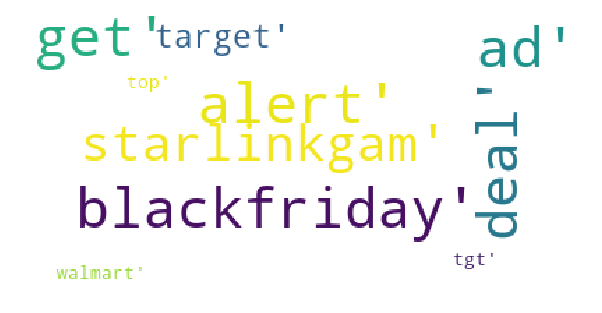

In [30]:
wordcloud_data = [[i[0]] * i[1] for i in top]
wordcloud_list = [word for word_list in wordcloud_data for word in word_list]

def show_wordcloud(data):

    '''
    This function takes in a list of words and creates a word cloud. 
    
    Args:
    -----
    data : List
    
    '''
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_font_size=40, 
        random_state=0,
        collocations=False
    ).generate(str(data))

    fig = plt.figure(1, figsize = (10, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

show_wordcloud(wordcloud_list)

## Multi-dimensional Data

In [3]:
df = pd.read_csv("creditcard.csv")
y_true = df['Class']
df_data = df.drop('Class',1)

In [4]:
Modify_std = preprocessing.StandardScaler()
data_strans = Modify_std.fit_transform(df_data)
Credit_data_for = pd.DataFrame(data_strans)

## Isolation Forest

In [5]:
Isolation_forest_model = ensemble.IsolationForest(contamination = 0.05)
Isolation_forest_model.fit(Credit_data_for)

IsolationForest(bootstrap=False, contamination=0.05, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
        verbose=0)

In [161]:
scoring = - Isolation_forest_model.decision_function(Credit_data_for)

In [51]:
Isola_result = Credit_data_for
Isola_result['Isolation_forest'] = pd.Series(Isolation_forest_model.predict(Isola_result))
Isola_result['Isolation_forest'] = Isola_result['Isolation_forest'].map( {1: 0, -1: 1} )

In [162]:
print("AUC Sore is ", round(metrics.roc_auc_score(y_true, scoring), 3))
print("F1 Score is ", round(metrics.f1_score(y_true, Isola_result['Isolation_forest']), 3))
print("Recall Score is ", round(metrics.recall_score(y_true, Isola_result['Isolation_forest']), 3))
print("Precision Score is ", round(metrics.precision_score(y_true, Isola_result['Isolation_forest']), 3))

AUC Sore is  0.946
F1 Score is  0.086
Recall Score is  0.793
Precision Score is  0.046


## K Means

In [59]:
KMeans_data = pd.DataFrame(Credit_data_for)
    
distance = get_distance(KMeans_data, cluster.KMeans(n_clusters = 4).fit(KMeans_data))

In [60]:
outliers_fraction = 0.05
number_of_outliers = int(outliers_fraction * len(distance))

In [61]:
threshold = distance.nlargest(number_of_outliers).min()    
KMeans_data['kmeans'] = (distance >= threshold).astype(int)

In [62]:
print("F1 Score is ", round(metrics.f1_score(y_true, KMeans_data['kmeans']), 3))
print("Recall Score is ", round(metrics.recall_score(y_true, KMeans_data['kmeans']), 3))
print("AUC Score is ", round(metrics.roc_auc_score(y_true, KMeans_data['kmeans']), 3))

AUC Sore is  0.056
Recall Score is  0.843
AUC Sore is  0.897


## One Class SVM

In [63]:
def train_SVM_Model(data_tn):
    model = svm.OneClassSVM()
    model_built = []
    for val in range(5):
        data_tn_new = data_tn.sample(50000)
        model.fit(data_tn_new)
        model_built.append(model)
    return model_built

In [64]:
def predict_class(data_tn,model_built):
    pred = np.zeros(data_tn.shape[0])
    for mod in model_built:
        pred = np.add(pred,mod.decision_function(data_tn).reshape(data_tn.shape[0],))
    divsision = len(data_tn)
    pred = (pred * 1.0)
    pred = pred/divsision
    return pred

In [65]:
model_built = train_SVM_Model(Credit_data_for)

In [66]:
y_hat = predict_class(Credit_data_for, model_built)

In [67]:
y_hat = -1 * y_hat

y_hat_class = y_hat.copy()
y_hat_class[ y_hat >= np.percentile(y_hat, 95)] = 1
y_hat_class[y_hat < np.percentile(y_hat, 95)] = 0

In [69]:
metrics.confusion_matrix(y_true, y_hat_class)

array([[270505,  13810],
       [    61,    431]], dtype=int64)

In [163]:
print("F1 Score is ", round(metrics.f1_score(y_true, y_hat_class), 3))
print("Recall Score is ", round(metrics.recall_score(y_true,y_hat_class), 3))
print("AUC Score is ", metrics.roc_auc_score(y_true, y_hat))

F1 Score is  0.059
Recall Score is  0.876
AUC Score is  0.9535741231706674
